In [1]:
%run flow_tools.py

In [2]:
folders = ['../data/20211030_LCBCAR_72hr/']

In [3]:
df = [load_data(folder, colnames = ['WellName', 'Target', 'Effector', 'Stain','Ratio', 'Replicate']) for folder in folders]
df = pd.concat(df)

In [4]:
#remove all rows with values less than 0
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]

#remove all rows with missing values
df2= df2.dropna()

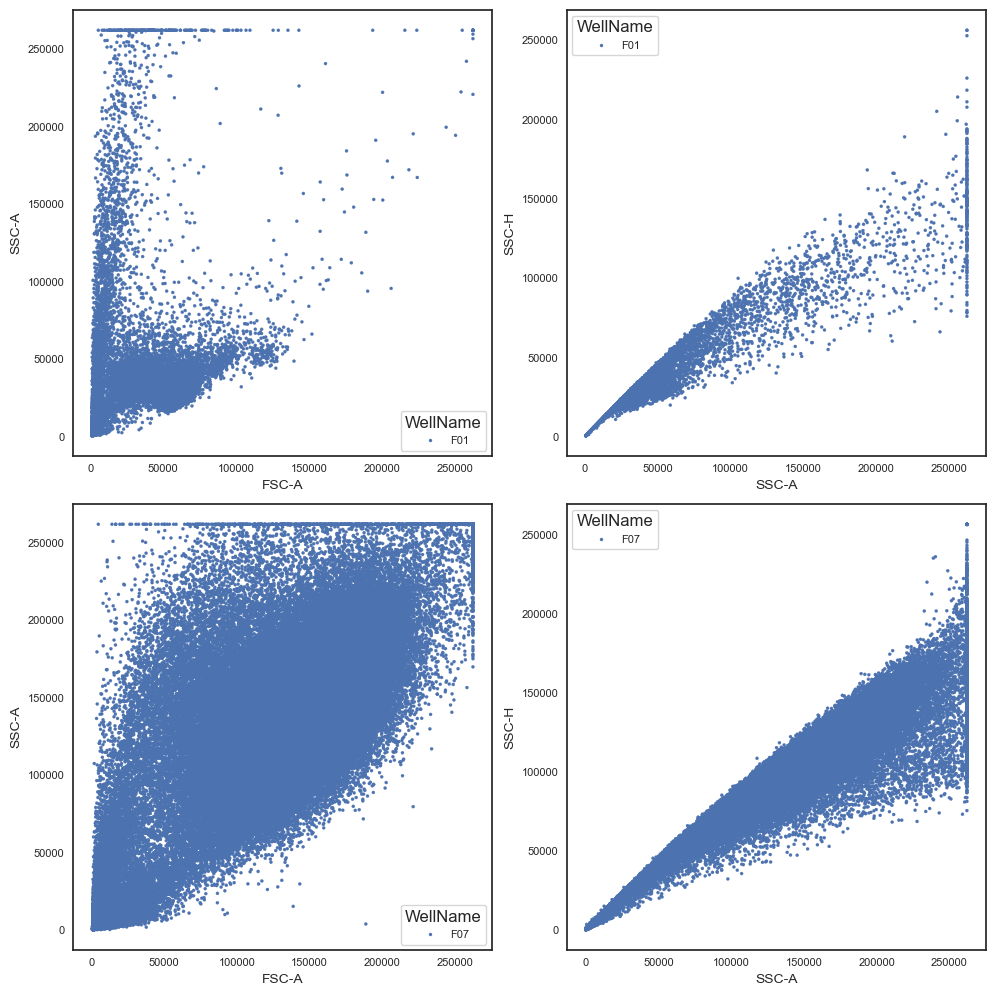

In [5]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[df2['WellName'].isin(['F01'])], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['F01'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['F07'])], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['F07'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
plt.tight_layout()

In [6]:
# based on above plots, we select upper and lower bounds to filter out junk
# filter by size, only including larger events
df2 =df2[df2["FSC-A"]>4E4]
# filter by granularity, removing all low granular events
df2 =df2[df2["SSC-A"]>1E4]
# filter by granularity, removing very high granular events
df2 =df2[df2["SSC-A"]<2.5E5]

# using density estimation, remove 'outliers' in FSC vs SSC plot
# the second argument in each of these functions is how much of the population
# to discard. here we use 0.1 to remove 10% of the population.
# for super clean experiments, lower is better. but if cell health is limited,
# you might need to increase this value

#first we gate in the FSC vs SSC plot to find our cells:
#df2 = gate_density(df2, 0.1, x_var='FSC-A',y_var='SSC-A')
#then we gate in the SSC-A vs SSC-H plot to gate singlets
df2 = gate_density(df2, 0.2, x_var='SSC-A',y_var='SSC-H')

# create new dataframe columns for log transformed data
for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

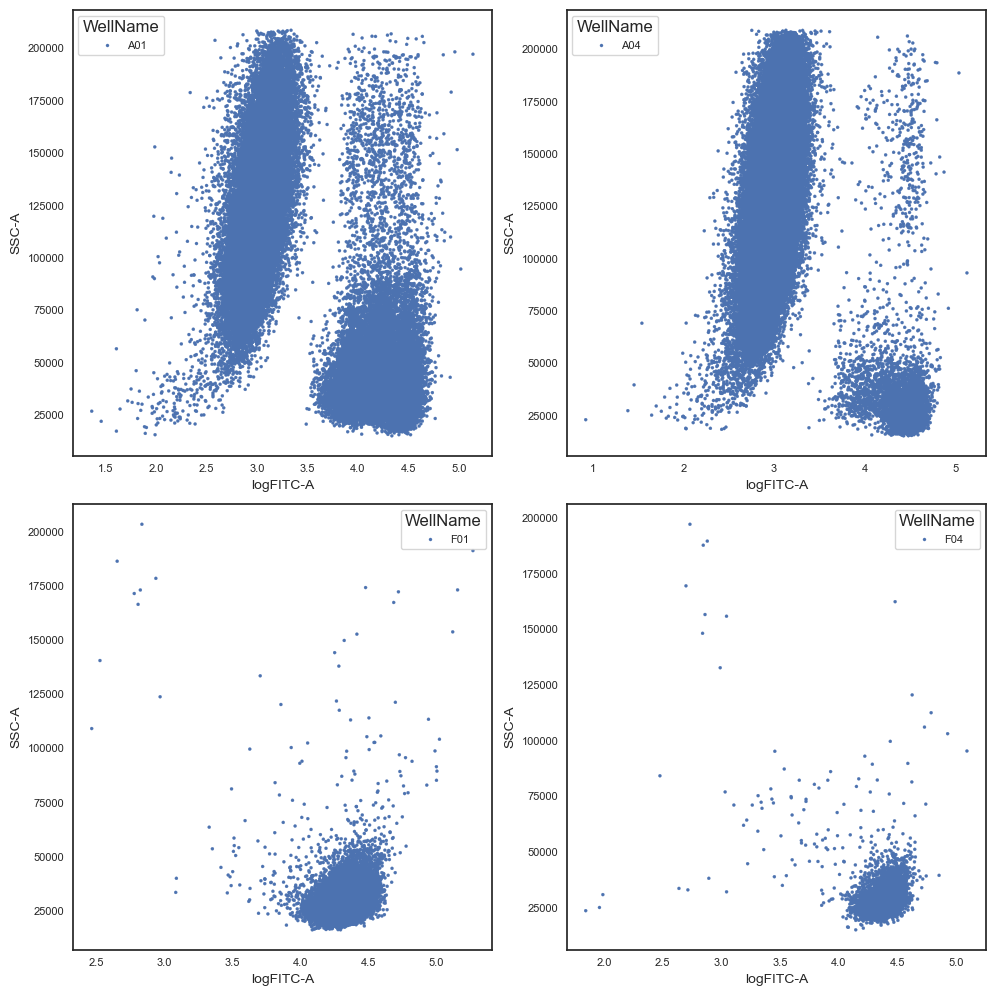

In [7]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[df2['WellName'].isin(['A01'])], x='logFITC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A04'])], x='logFITC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['F01'])], x='logFITC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['F04'])], x='logFITC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
plt.tight_layout()

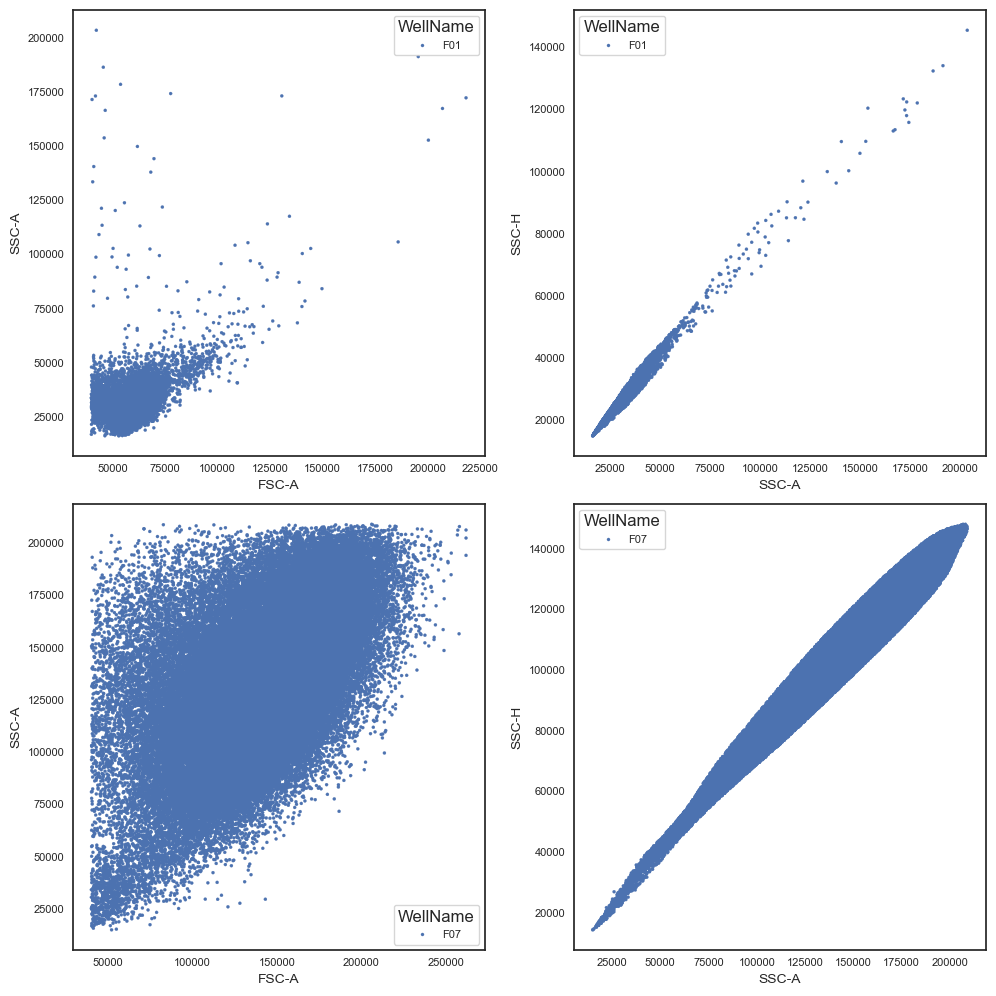

In [8]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[df2['WellName'].isin(['F01'])], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['F01'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['F07'])], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['F07'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
plt.tight_layout()

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` i

Text(0.5, 23.999999999999986, 'log <channel>')

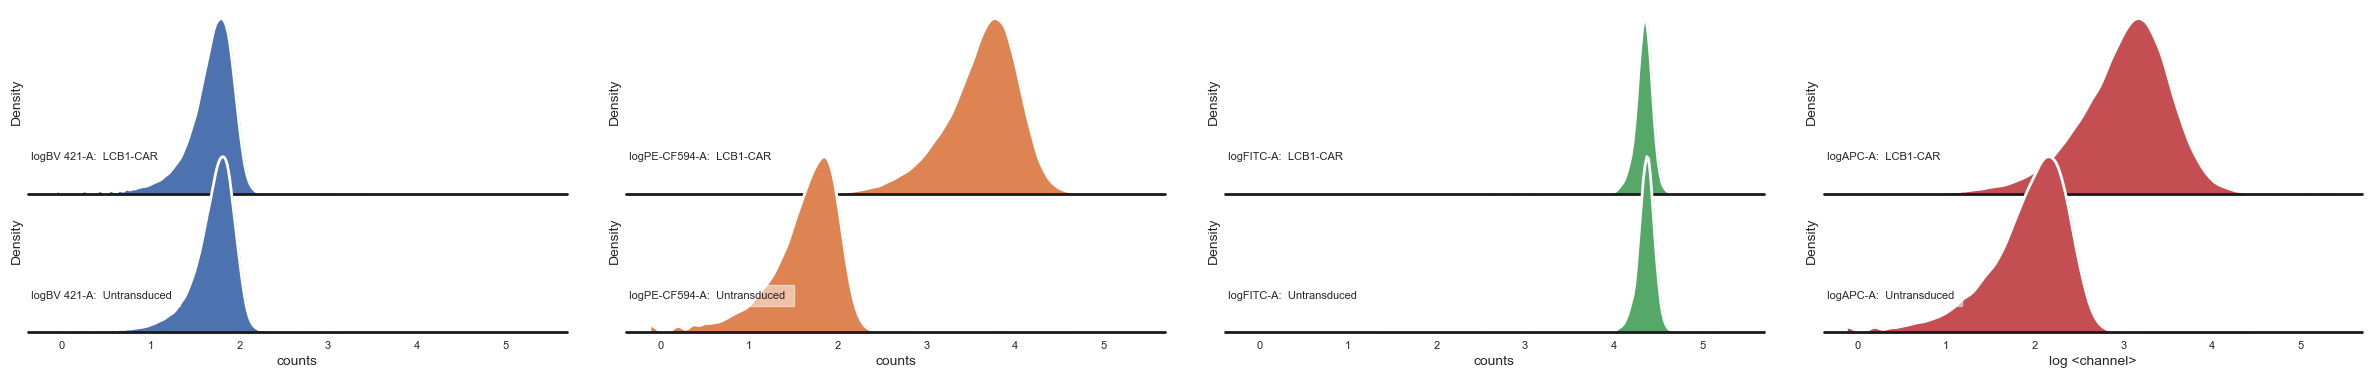

In [9]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logBV 421-A','logPE-CF594-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','WellName','Effector', 'Ratio'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Ratio"].isin(['None'])) &
                                     ~(simplified_df['Effector'].isin(['None']))], 
                  row = 'Effector', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` i

Text(0.5, 23.999999999999986, 'log <channel>')

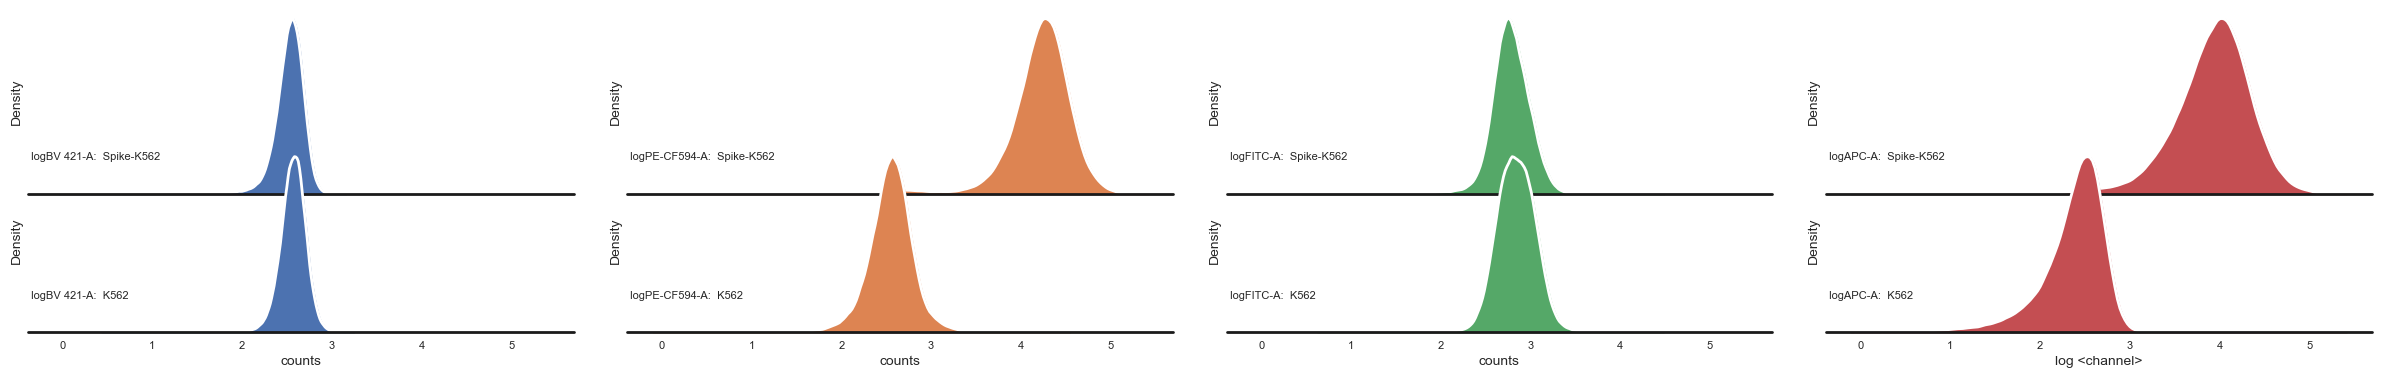

In [10]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logBV 421-A','logPE-CF594-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','WellName','Target', 'Ratio'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Ratio"].isin(['None'])) &
                                     ~(simplified_df['Target'].isin(['None']))], 
                  row = 'Target', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

In [11]:
effectors = ['LCB1-CAR', 'Untransduced']
targets = ['K562', 'Spike-K562']
colors = {'Untransduced + K562' : '#8C9696',
          'Untransduced + Spike-K562' : '#6F7978',
          'LCB1-CAR + K562' : '#4272B8',
          'LCB1-CAR + Spike-K562' : '#2158A4'}
linestyles = {'K562' : ':', 'Spike-K562': '-'}
markers = {'K562' : 'o', 'Spike-K562': '^'}

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` i

Text(0.5, 23.999999999999986, 'log <channel>')

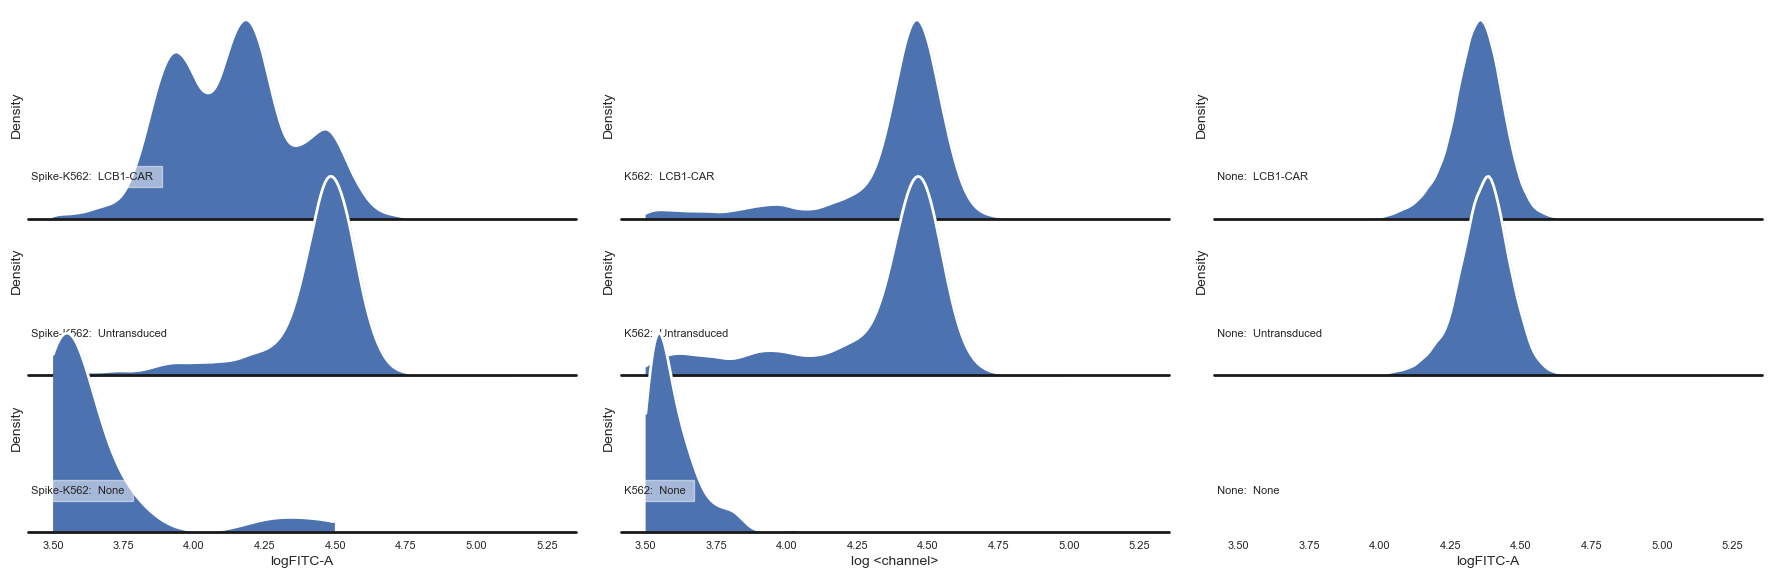

In [12]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
g = sns.FacetGrid(data=df2[(df2['Ratio'].isin(['1:1','None'])) &
                           (df2['logFITC-A'] > 3.5)], row = 'Effector', col='Target', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "logFITC-A", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "logFITC-A", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

In [13]:
expression_df = (df2[(df2['Target']=='None') &
                     (df2['Stain']=='Myc')]
                 .groupby(['Effector','Replicate'])['APC-A']
                 .median()
                 .reset_index())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


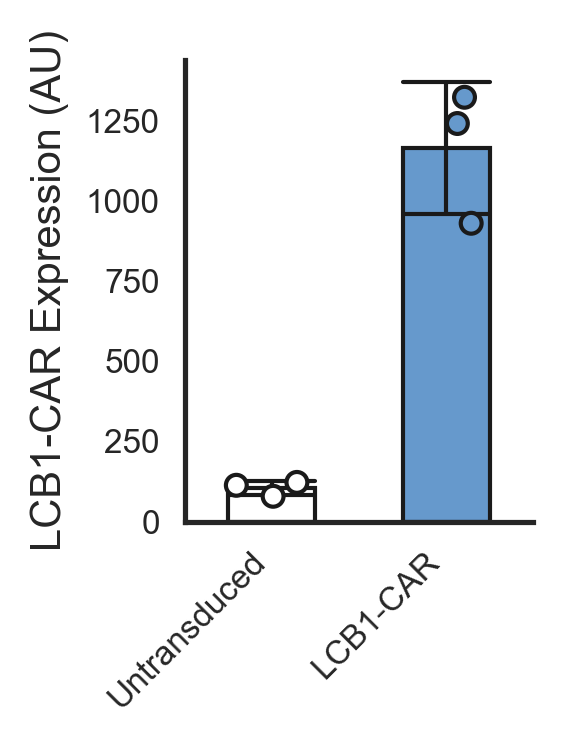

In [14]:
with sns.color_palette([white, light_blue]):
    fig, ax = plt.subplots(1,1,figsize=(1.5,2), dpi=300)
    g = sns.stripplot(data=expression_df, x='Effector', y='APC-A', hue='Effector',
                  order=['Untransduced','LCB1-CAR'],
                  hue_order=['Untransduced','LCB1-CAR'], 
                  edgecolor='k', linewidth=1, jitter=0.25)
    sns.barplot(data=expression_df, x='Effector', y='APC-A', hue='Effector',
                  order=['Untransduced','LCB1-CAR'],
                  hue_order=['Untransduced','LCB1-CAR'],
                errorbar='sd', 
            dodge=False, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
            err_kws={'linewidth': 1, 'color':'k'})
    g.legend().remove()
    g.set_ylabel('LCB1-CAR Expression (AU)')
    g.set_xlabel('')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.savefig(outputdir+'lcbcar-expression-init.pdf', bbox_inches='tight')

In [15]:
activation_df = (df2[~(df2['Target']=='None') &
                     ~(df2['Effector']=='None') &
                    (df2['logFITC-A'] > 3.5)]
                 .groupby(['Effector','Target','Ratio','Replicate'])['logAPC-A']
                 .median()
                 .reset_index())

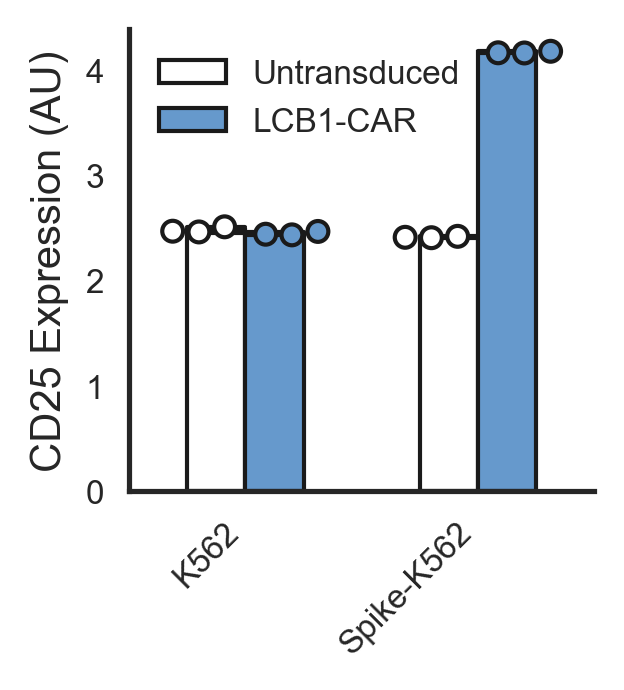

In [16]:
with sns.color_palette([white, light_blue]):
    fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
    sns.swarmplot(data=activation_df[activation_df['Ratio']=='1:1'],
                      x='Target', y='logAPC-A', hue='Effector',
                  order=['K562','Spike-K562'],
                  hue_order=['Untransduced','LCB1-CAR'], 
                  edgecolor='k', linewidth=1, dodge=True)
    g= sns.barplot(data=activation_df[activation_df['Ratio']=='1:1'], x='Target', y='logAPC-A', hue='Effector',
                  order=['K562','Spike-K562'],
                  hue_order=['Untransduced','LCB1-CAR'], 
                errorbar='sd',
                estimator='mean',
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
            err_kws={'linewidth': 1, 'color':'k'})
    g.legend().remove()
    g.set_ylabel('CD25 Expression (AU)')
    g.set_xlabel('')
    plt.xticks(rotation=45, ha='right')
    handles, labels = ax.get_legend_handles_labels()
    order = [2,3]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False)
    sns.despine()
    plt.savefig(outputdir + 'cd25_activation_init.pdf', bbox_inches="tight")

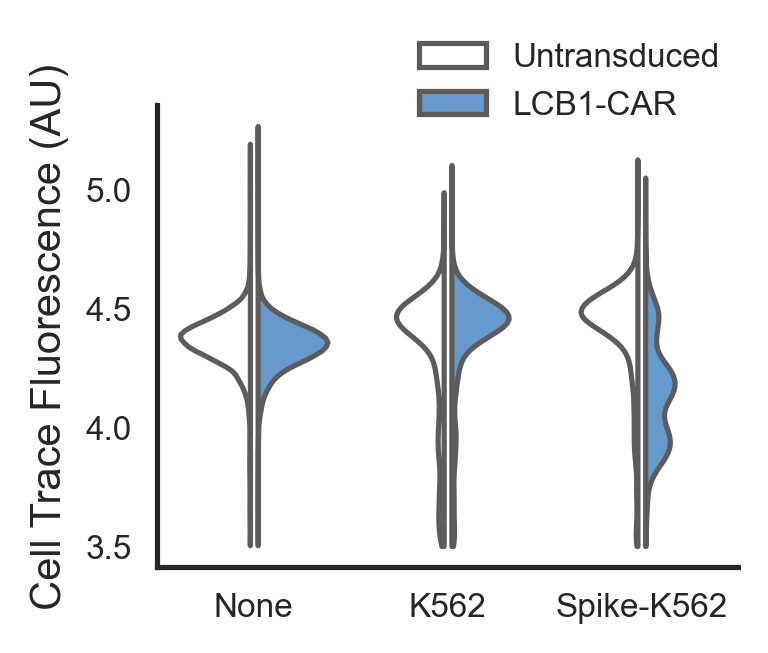

In [17]:
with sns.color_palette([white, light_blue]):
    fig, ax = plt.subplots(1,1,figsize=(2.5,2), dpi=300)
    g = sns.violinplot(data=df2[(df2['Ratio'].isin(['1:1','None'])) &
                            (df2['logFITC-A']>3.5) &
                            (df2['Effector'].isin(['LCB1-CAR','Untransduced']))],
                   x='Target',
                   y='logFITC-A',
                   hue='Effector',
                   hue_order=['Untransduced', 'LCB1-CAR'],
                   order=['None', 'K562', 'Spike-K562'],
                       saturation=1,
                   split=True, legend=True, inner=None, cut=0, gap=0.1, common_norm=False,)
    g.legend(loc='upper left', bbox_to_anchor=[0.4,1.2], frameon=False)
    plt.xlabel('')
    sns.despine()
    plt.ylabel('Cell Trace Fluorescence (AU)')
    
plt.savefig(outputdir + 'proliferation_init.pdf', bbox_inches="tight")

In [18]:
count_df = (df2[df2['Stain']=='CD25']
                 .groupby(['WellName','Effector','Target','Ratio','Replicate'])['logFITC-A']
                 .agg(Effectors=(lambda x: np.sum(x>3.5)),
                      Targets=(lambda x: np.sum(x<3.5)))
                 .reset_index())

In [19]:
count_df['Lysis'] = np.nan
for target in ['Spike-K562', 'K562']:
    target_filter = (count_df['Target'] == target)
    baseline = count_df[(count_df['Ratio'] == 'Target Only') &
                        target_filter]['Targets'].mean()
    count_df.loc[target_filter, 'Lysis'] = 100*(1-(count_df[target_filter]['Targets']/baseline))

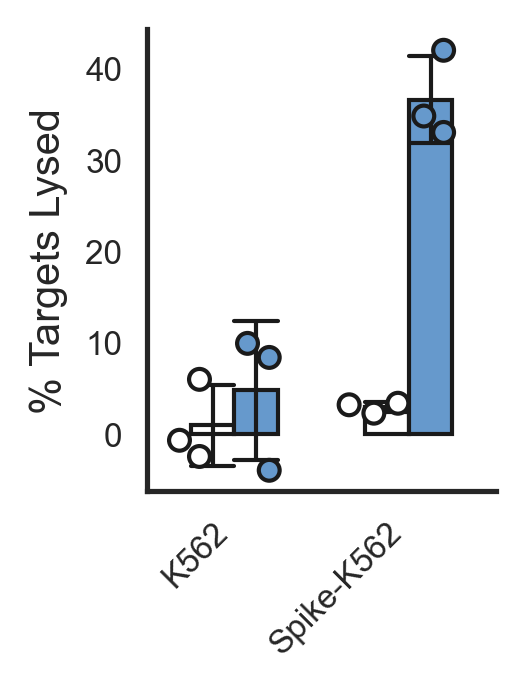

In [20]:
with sns.color_palette([white, light_blue]):
    fig, ax = plt.subplots(1,1,figsize=(1.5,2), dpi=300)
    effectors = ['Untransduced', 'LCB1-CAR']
    g = sns.swarmplot(data=count_df[(count_df['Ratio']=='2:1') &
                                    (count_df['Effector'].isin(effectors))], 
                      x='Target', y='Lysis', hue='Effector',
                  order=['K562', 'Spike-K562'],
                  hue_order=effectors, 
                  edgecolor='k', linewidth=1, dodge=True)
    sns.barplot(data=count_df[(count_df['Ratio']=='2:1') &
                              (count_df['Effector'].isin(effectors))], 
                x='Target', y='Lysis', hue='Effector',
                  order=['K562', 'Spike-K562'],
                  hue_order=effectors,
                errorbar='sd',
                estimator = 'mean',
            dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
            err_kws={'linewidth': 1, 'color':'k'})
    g.legend().remove()
    g.set_ylabel('% Targets Lysed')
    g.set_xlabel('')
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.savefig(outputdir+'2to1_lysis_init.pdf', bbox_inches='tight')

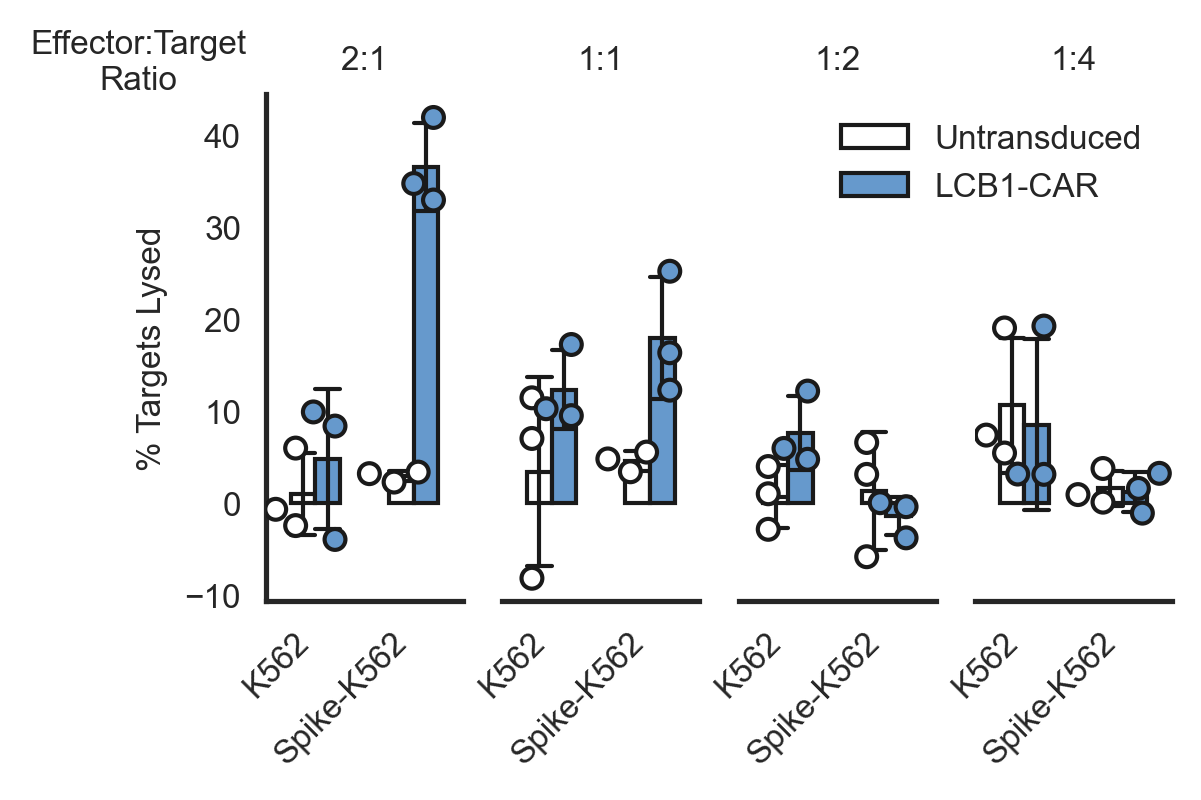

In [21]:
ratios = ['2:1', '1:1', '1:2', '1:4']
effectors = ['Untransduced','LCB1-CAR']
g = sns.catplot(kind='swarm', data=count_df[(count_df['Ratio'].isin(ratios)) &
                                (count_df['Effector'].isin(effectors))],
                col='Ratio', hue='Effector', aspect=0.4, x='Target', y='Lysis', palette=[white, light_blue],
                order=['K562', 'Spike-K562'], hue_order=effectors, edgecolor='k', linewidth=1, dodge=True)
g.map_dataframe(sns.barplot, x='Target', y='Lysis', order=['K562', 'Spike-K562'],
                hue_order=effectors, errorbar='sd', hue='Effector',palette=[white, light_blue],
                dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                err_kws={'linewidth': 1, 'color':'k'})
g.figure.set_size_inches(3.8,2)
g.figure.set_dpi(300)
g.set_xlabels('')
g.set_xticklabels(rotation=45, ha='right', size=SMALL_SIZE)
g.fig.subplots_adjust(wspace=0.2)
g.set_titles(col_template='{col_name}', size=SMALL_SIZE)
g.legend.remove()
handles, labels = g.axes.flat[0].get_legend_handles_labels()
order = [0,1]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper right')
for ax in g.axes.flat[1:]:
    ax.spines[['left']].set_visible(False)
g.set_ylabels('% Targets Lysed', size=SMALL_SIZE)
plt.figtext(-0.05, 0.95, 'Effector:Target\nRatio', size=SMALL_SIZE, horizontalalignment='center')
plt.savefig(outputdir+'killing_init.pdf', bbox_inches='tight')